<center><H1>An introduction to S3, Boto and Nexrad on S3</H1></center>

Adapted from and thank to the first tutorial by Valliappa Lakshmanan, formerly at Climate Corp now at Google.

https://eng.climate.com/2015/10/27/how-to-read-and-display-nexrad-on-aws-using-python/

<a href='https://aws.amazon.com/s3'> Amazon Simple Storage Service (Amazon S3) </a> is object storage with a simple web service interface to store and retrieve any amount of data from anywhere on the web. It is designed to deliver 99.999999999% durability, and scale past trillions of objects worldwide.

<a href='https://github.com/boto/boto'>Boto </a>is a Python package that provides interfaces to Amazon Web Services.

In [19]:
#Lets import some stuff!
import boto
from boto.s3.connection import S3Connection
from datetime import timedelta, datetime
import os
import pyart
from matplotlib import pyplot as plt
import tempfile
import numpy as np

%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



From https://aws.amazon.com/noaa-big-data/nexrad/ :

The NEXRAD Level II archive data is hosted in the “noaa-nexrad-level2” Amazon S3 bucket in S3’s US East region. The address for the public bucket is:

http://noaa-nexrad-level2.s3.amazonaws.com

https://noaa-nexrad-level2.s3.amazonaws.com

Each volume scan file is its own object in Amazon S3.  The basic data format is the following:

`/<Year>/<Month>/<Day>/<NEXRAD Station>/<filename>`

Where:

<Year> is the year the data was collected
<Month> is the month of the year the data was collected
<Day> is the day of the month the data was collected
<NEXRAD Station> is the NEXRAD ground station (map of ground stations)
<filename> is the name of the file containing the data. These are compressed files (compressed with gzip). The file name has more precise timestamp information.

All files in the archive use the same compressed format (.gz). The data file names are, for example, KAKQ20010101_080138.gz. The file naming convention is:

GGGGYYYYMMDD_TTTTTT

Where:

GGGG = Ground station ID (map of ground stations)
YYYY = year
MM = month
DD = day
TTTTTT = time when data started to be collected (GMT)

Note that the 2015 files have an additional field on the file name. It adds “_V06” to the end of the file name. An example is KABX20150303_001050_V06.gz.

In [20]:
#first lets connect to the bucket
conn = S3Connection(anon = True)
bucket = conn.get_bucket('noaa-nexrad-level2')

In [21]:
#as we can see there is a LOT we can do with a bucket!!!
dir(bucket)

['BucketPaymentBody',
 'LoggingGroup',
 'MFADeleteRE',
 'VersionRE',
 'VersioningBody',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_delete_key_internal',
 '_get_all',
 '_get_all_query_args',
 '_get_key_internal',
 'add_email_grant',
 'add_user_grant',
 'cancel_multipart_upload',
 'complete_multipart_upload',
 'configure_lifecycle',
 'configure_versioning',
 'configure_website',
 'connection',
 'copy_key',
 'delete',
 'delete_cors',
 'delete_key',
 'delete_keys',
 'delete_lifecycle_configuration',
 'delete_policy',
 'delete_tags',
 'delete_website_configuration',
 'disable_logging',
 'enable_logging',
 'endElement',
 'generate_url',
 

The contents of the bucket are in bucket.list

In [22]:
my_list = bucket.list()
help(my_list)

Help on BucketListResultSet in module boto.s3.bucketlistresultset object:

class BucketListResultSet(builtins.object)
 |  BucketListResultSet(bucket=None, prefix='', delimiter='', marker='', headers=None, encoding_type=None)
 |  
 |  A resultset for listing keys within a bucket.  Uses the bucket_lister
 |  generator function and implements the iterator interface.  This
 |  transparently handles the results paging from S3 so even if you have
 |  many thousands of keys within the bucket you can iterate over all
 |  keys in a reasonably efficient manner.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, bucket=None, prefix='', delimiter='', marker='', headers=None, encoding_type=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __iter__(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__


We can see this is an iterator.. Printing the whole list would be **YUUUUGE!** so we want to subset it.. we can do this via the prefix keyword. We are then going to cast it to a list

In [23]:
my_pref = '2011/05/20/KVNX/'
bucket_list = list(bucket.list(prefix = my_pref))

In [24]:
print(bucket_list[0:10])


[<Key: noaa-nexrad-level2,2011/05/20/KVNX/KVNX20110520_000023_V06.gz>, <Key: noaa-nexrad-level2,2011/05/20/KVNX/KVNX20110520_000442_V06.gz>, <Key: noaa-nexrad-level2,2011/05/20/KVNX/KVNX20110520_000901_V06.gz>, <Key: noaa-nexrad-level2,2011/05/20/KVNX/KVNX20110520_001320_V06.gz>, <Key: noaa-nexrad-level2,2011/05/20/KVNX/KVNX20110520_001740_V06.gz>, <Key: noaa-nexrad-level2,2011/05/20/KVNX/KVNX20110520_002201_V06.gz>, <Key: noaa-nexrad-level2,2011/05/20/KVNX/KVNX20110520_002620_V06.gz>, <Key: noaa-nexrad-level2,2011/05/20/KVNX/KVNX20110520_003040_V06.gz>, <Key: noaa-nexrad-level2,2011/05/20/KVNX/KVNX20110520_003459_V06.gz>, <Key: noaa-nexrad-level2,2011/05/20/KVNX/KVNX20110520_003918_V06.gz>]


So we have a list of key (objects) in an S3 bucket. We can directly access the item and download it to a file using the contents_to_file method

In [25]:
home_dir = os.path.expanduser('~')
bucket_list[0].get_contents_to_filename(os.path.join(home_dir,'nexrad_tempfile'))

OK!! That was easy.. lets just take a quick look

In [26]:
radar = pyart.io.read(os.path.join(home_dir,'nexrad_tempfile'))

In [27]:
print(radar.info())

altitude:
	data: <ndarray of type: float64 and shape: (1,)>
	long_name: Altitude
	standard_name: Altitude
	units: meters
	positive: up
altitude_agl: None
antenna_transition: None
azimuth:
	data: <ndarray of type: float64 and shape: (8280,)>
	units: degrees
	standard_name: beam_azimuth_angle
	long_name: azimuth_angle_from_true_north
	axis: radial_azimuth_coordinate
	comment: Azimuth of antenna relative to true north
elevation:
	data: <ndarray of type: float32 and shape: (8280,)>
	units: degrees
	standard_name: beam_elevation_angle
	long_name: elevation_angle_from_horizontal_plane
	axis: radial_elevation_coordinate
	comment: Elevation of antenna relative to the horizontal plane
fields:
	cross_correlation_ratio:
		data: <ndarray of type: float32 and shape: (8280, 1832)>
		units: ratio
		standard_name: cross_correlation_ratio_hv
		long_name: Cross correlation_ratio (RHOHV)
		valid_max: 1.0
		valid_min: 0.0
		coordinates: elevation azimuth range
		_FillValue: -9999.0
	reflectivity:
		data: 

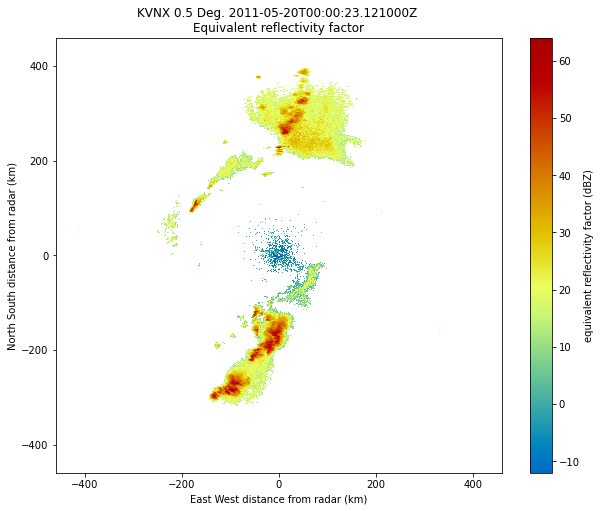

In [28]:
my_figure = plt.figure(figsize = [10,8])
my_display = pyart.graph.RadarDisplay(radar)
my_display.plot_ppi('reflectivity', 0, vmin = -12, vmax = 64)

Ok! How do I search for the volume **I** want? And make it open easily in Py-ART? Here is a little documented script

In [29]:
#Helper function for the search
def _nearestDate(dates, pivot):
    return min(dates, key=lambda x: abs(x - pivot))


def get_radar_from_aws(site, datetime_t):
    """
    Get the closest volume of NEXRAD data to a particular datetime.
    Parameters
    ----------
    site : string
        four letter radar designation
    datetime_t : datetime
        desired date time
    Returns
    -------
    radar : Py-ART Radar Object
        Radar closest to the queried datetime
    """

    #First create the query string for the bucket knowing
    #how NOAA and AWS store the data

    my_pref = datetime_t.strftime('%Y/%m/%d/') + site

    #Connect to the bucket

    conn = S3Connection(anon = True)
    bucket = conn.get_bucket('noaa-nexrad-level2')

    #Get a list of files

    bucket_list = list(bucket.list(prefix = my_pref))

    #we are going to create a list of keys and datetimes to allow easy searching

    keys = []
    datetimes = []

    #populate the list

    for i in range(len(bucket_list)):
        this_str = str(bucket_list[i].key)
        if 'gz' in this_str:
            endme = this_str[-22:-4]
            fmt = '%Y%m%d_%H%M%S_V0'
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

        if this_str[-3::] == 'V06':
            endme = this_str[-19::]
            fmt = '%Y%m%d_%H%M%S_V06'
            dt = datetime.strptime(endme, fmt)
            datetimes.append(dt)
            keys.append(bucket_list[i])

    #find the closest available radar to your datetime

    closest_datetime = _nearestDate(datetimes, datetime_t)
    index = datetimes.index(closest_datetime)

    localfile = tempfile.NamedTemporaryFile()
    keys[index].get_contents_to_filename(localfile.name)
    radar = pyart.io.read(localfile.name)
    return radar

Lets take it for a spin!

/Users/bem/opt/miniconda3/envs/tropycal/lib/python3.10/site-packages/pyart/graph/radarmapdisplay.py:256: UserWarning: No projection was defined for the axes. Overridding defined axes and using default axes.
  warnings.warn("No projection was defined for the axes."
/Users/bem/opt/miniconda3/envs/tropycal/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lines.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/Users/bem/opt/miniconda3/envs/tropycal/lib/python3.10/site-packages/pyart/graph/radarmapdisplay.py:507: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.get_path().vertices.tolist())
/Users/bem/opt/miniconda3/envs/tropycal/lib/python3.10/site-packages/pyart/graph/radarmapdisplay.py:507: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxe

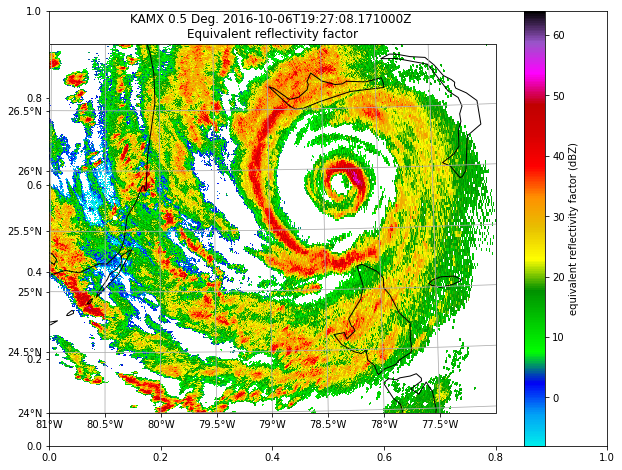

In [31]:
base_date = "20161006_192700"
fmt = '%Y%m%d_%H%M%S' 
b_d = datetime.strptime(base_date, fmt)

my_radar = get_radar_from_aws('KAMX',b_d )
max_lat = 27
min_lat = 24
min_lon = -81
max_lon = -77

lal = np.arange(min_lat, max_lat, .5)
lol = np.arange(min_lon, max_lon, .5)

display = pyart.graph.RadarMapDisplay(my_radar)
fig = plt.figure(figsize = [10,8])
display.plot_ppi_map('reflectivity', sweep = 0, resolution = '50m',
                    vmin = -8, vmax = 64, mask_outside = False,
                    cmap = pyart.graph.cm.NWSRef,
                    min_lat = min_lat, min_lon = min_lon,
                    max_lat = max_lat, max_lon = max_lon,
                    lat_lines = lal, lon_lines = lol)